<center>
<img src="Stone_Soup_Icon_Final_small.png">
<h1>Stone Soup Metrics Demo</h1>
Demonstrating how to generate metrics in Stone Soup
</center>

# Run a Stone Soup tracker



In [1]:
import numpy as np
import datetime
import matplotlib
%matplotlib notebook

In [2]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))

In [3]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

In [4]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=GaussianState(
        StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10]))),
    timestep=datetime.timedelta(seconds=5),
    birth_rate=0.3,
    death_probability=0.05
)

In [5]:
from stonesoup.simulator.simple import SimpleDetectionSimulator

detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    meas_range=np.array([[-1, 1], [-1, 1]])*5000,  # Area to generate clutter
    detection_probability=0.9,
    clutter_rate=3,
)

In [6]:
groundtruth_paths = set()  # Store for plotting later
detections = set()  # Store for plotting later

for time, cdetections in detection_sim.detections_gen():
    detections |= cdetections
    groundtruth_paths |= groundtruth_sim.groundtruth_paths

In [7]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

In [8]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

In [9]:
from stonesoup.hypothesiser.distance import MahalanobisDistanceHypothesiser
hypothesiser = MahalanobisDistanceHypothesiser(predictor, updater)

In [10]:
from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

In [11]:
from stonesoup.initiator.simple import SinglePointInitiator
initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

In [13]:
from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

In [14]:
from stonesoup.tracker.simple import MultiTargetTracker
tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detection_sim,
    data_associator=data_associator,
    updater=updater,
)

In [15]:
tracks = dict()
detections = set()
groundtruth_paths = set()
for time, ctracks in tracker.tracks_gen():
    detections.update(tracker.detector.detections)
    groundtruth_paths.update(tracker.detector.groundtruth.groundtruth_paths)
    
    ctrack_dict = {track.id:track for track in ctracks}
    tracks.update(ctrack_dict)
    
tracks= set(tracks.values())

At this point the *detections* produced from the *groundtruth_paths* have been used to create *tracks*.

The next step is to generate metrics to see how well that has been done.

# Setting up the metric manager

There are three components to consider when creating metrics:
- The MetricManager objects parses and store the input data (such as the tracks and groundtruth) and calls the MetricGenerators assigned to it
- The MetricGenerator objects process the data and produce Metrics.
- The Metric objects store the metric information

First we create the MetricGenerators, some of which have their own parameters than need defining.

BasicMetrics currently does very simple analysis of the tracks and truth simply measuring the number of tracks, truth paths and the track/truth ratio.

OSPAMetric calculates the OSPA metric at each timestep (the average difference between state estimations and truth positions).

TwoDPlotter plots the tracks on a 2d image

SiapMetrics computes the SIAP (Single Integrated Air Picture) metrics

In [17]:
from stonesoup.metricgenerator.basicmetrics import BasicMetrics
from stonesoup.metricgenerator.basicmetrics import OSPAMetric
from stonesoup.metricgenerator.plotter import TwoDPlotter

basic_calculator = BasicMetrics()
ospa_calculator = OSPAMetric(c=10,p=1,measurement_matrix_meas = measurement_model.matrix(), measurement_matrix_truth = measurement_model.matrix())
plotter = TwoDPlotter(track_indices = [0,2], gtruth_indices = [0,2], detection_indices = [0,1])


The metric manager is initialised with the MetricGenerators that it will be running. The data is then imported. When the data is imported the class of the data is checked and stored appropriately (e.g. if a Track type data is imported then it is assumed that this is the track produced from a tracker).

The add_data function by default appends any additional data. Using the overwrite=True flag instead replaces the current data with the new data.

For the SIAP metrics we also requrie an associator to associate tracks to truths

## Associators

An associator links together various objects, in this case ground truth and tracks. The associator is added to the metric manager and when called populates the internam metric_manager.association_set.

An association_set, as the name suggests, contains a set of associations (in association_set.objects) and also includes the ability to select from that set for associations at a given timstamp or including a given object.

An association includes the objects being associated and the time range over which the association is valid

In [18]:
from stonesoup.dataassociator.tracktotrack import EuclidianTrackToTruth
from stonesoup.metricgenerator.tracktotruthmetrics import SiapMetrics

associator = EuclidianTrackToTruth(measurement_matrix_truth = measurement_model.matrix(), measurement_matrix_track = measurement_model.matrix(),
                                  association_threshold = 30)
siap_calculator = SiapMetrics()

In [19]:
from stonesoup.metricgenerator.manager import SimpleManager
metric_manager = SimpleManager([basic_calculator,ospa_calculator,plotter, siap_calculator], associator = associator)
metric_manager.add_data((tracks,groundtruth_paths,detections))
metric_manager.associate_tracks()

To visualise the result of the association the below plot shows all the tracks and truth paths in grey the overlays the associated tracks in colour.

<IPython.core.display.Javascript object>


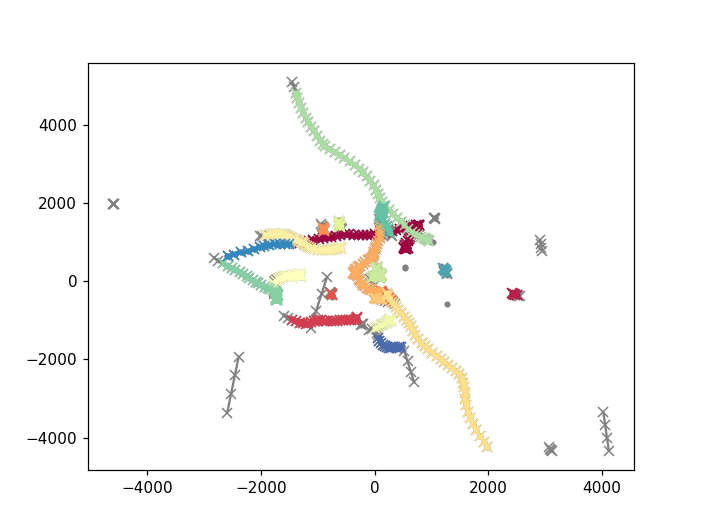

In [20]:
n_assoc= len(metric_manager.association_set.associations)
from stonesoup.types import GroundTruthPath
import matplotlib.pyplot as plt
import matplotlib
plt.figure()

cmap = matplotlib.cm.get_cmap('Spectral')

for track in tracks:
    plt.plot([i.state_vector[0] for i in track.states], [i.state_vector[2] for i in track.states], color = 'gray', marker = 'x')

for truth in groundtruth_paths:
    plt.plot([i.state_vector[0] for i in truth.states], [i.state_vector[2] for i in truth.states], color = 'gray', marker = '.')

for i_as, association in enumerate(metric_manager.association_set.associations):
    
    truth_assoc_data = [i for i in association.objects if isinstance(i,GroundTruthPath)][0]
    track_assoc_data= [i for i in association.objects if not isinstance(i,GroundTruthPath)][0]
    plt.plot([i.state_vector[0] for i in truth_assoc_data if association.time_range.start_timestamp <= i.timestamp <= association.time_range.end_timestamp],
             [i.state_vector[2] for i in truth_assoc_data if association.time_range.start_timestamp <= i.timestamp <= association.time_range.end_timestamp],
             linestyle = '-', marker = '.', color = cmap(i_as/n_assoc))
    plt.plot([i.state_vector[0] for i in track_assoc_data if association.time_range.start_timestamp <= i.timestamp <= association.time_range.end_timestamp],
             [i.state_vector[2] for i in track_assoc_data if association.time_range.start_timestamp <= i.timestamp <= association.time_range.end_timestamp],
             linestyle = '-', marker = 'x', color = cmap(i_as/n_assoc))


plt.show()

# Generate the metrics

Running generate_metrics calls all of the metric generators stored in the manager. As one of the metrics is a plot a diagram will probably appear below, I believe this is a quirk of Jupyter that it likes to plot even if plt.show() is not called

<IPython.core.display.Javascript object>


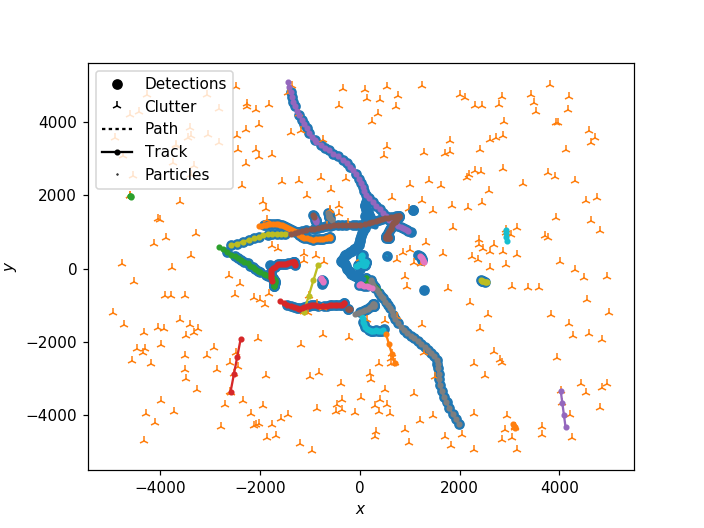

In [21]:
metrics = metric_manager.generate_metrics()

Most of the metrics are a smiple value

In [22]:
from stonesoup.types.metric import PlottingMetric

for metric in metrics:
    if metric.title not in ["OSPA distances", "Track plot"]:
        print(metric.title,":", metric.value)

SIAP C : 0.9385964912280702
SIAP LT : -340.0
SIAP LS : 0.9232558139534883
Number of tracks : 30
Number of targets : 26
Track-to-target ratio : 1.1538461538461537
SIAP A : 1.0
SIAP S : 0.13883299798792756


The plot metric is a matplotlib plot

<IPython.core.display.Javascript object>


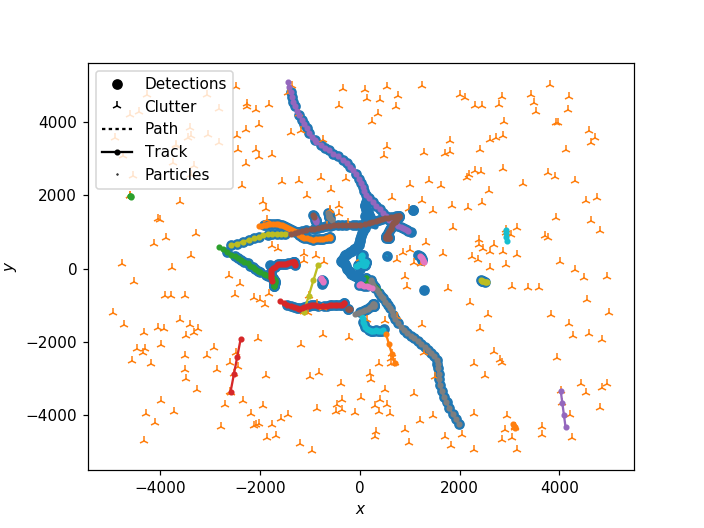

In [23]:
plot_metric = [i for i in metrics if i.title == "Track plot"][0]
plot_metric.value

The OSPA metric is a list of the OSPA distance at each timestep

<IPython.core.display.Javascript object>


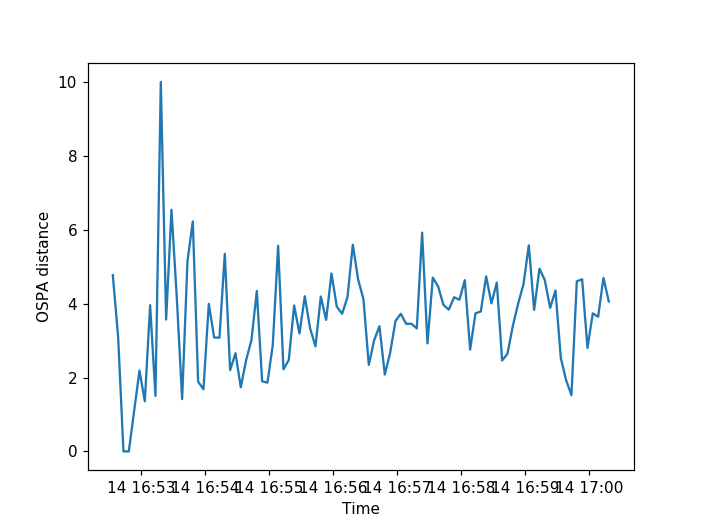

In [24]:
ospa_metric = [i for i in metrics if i.title == "OSPA distances"][0]

plt.figure()
plt.plot([i.timestamp for i in ospa_metric.value], [i.value for i in ospa_metric.value])
plt.ylabel("OSPA distance")
plt.xlabel("Time")
plt.show()